In [ ]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2

from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.applications.inception_v3 import preprocess_input

import cv2
import os
import random
import collections
from collections import defaultdict

from shutil import copy
from shutil import copytree, rmtree

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

In [ ]:
##import second libraries
import pandas as pd
import numpy as np 
import itertools
from math import sqrt
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential 
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense 
from keras import applications 
from keras.utils.np_utils import to_categorical 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math 
import datetime
import time

##Prepare Food101 Dataset

In [ ]:
def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    tf.keras.utils.get_file(
    'food-101.tar.gz',
    'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz',
    cache_subdir='/content',
    extract=True,
    archive_format='tar',
    cache_dir=None
    )
data_path = '/content/food-101/images'

In [ ]:
get_data_extract()

4996284416/4996278331 [==============================] - 267s 0us/step


In [ ]:
classes_images = defaultdict(list)
classes_images

defaultdict(list, {})

In [ ]:
def prepare_data(filepath, src, dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    #print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [ ]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
print("Creating train data...")
prepare_data('/content/food-101/meta/train.txt', '/content/food-101/images', '/content/food-101/train')

Creating train data...
Copying Done!


In [ ]:
print("Creating test data...")
prepare_data('/content/food-101/meta/test.txt', '/content/food-101/images', '/content/food-101/test')

Creating test data...
Copying Done!


In [ ]:
train_files = sum([len(files) for i, j, files in os.walk("/content/food-101/train")])
print("Total number of samples in train folder ",train_files)

Total number of samples in train folder  75750


In [ ]:
test_files = sum([len(files) for i, j, files in os.walk("/content/food-101/test")])
print("Total number of samples in test folder ",test_files)

Total number of samples in test folder  25250


In [ ]:
foods_sorted= os.listdir('/content/food-101/images')
foods_sorted = sorted(foods_sorted)

##Prepare Recipe5k Dataset

In [ ]:
testing_datapath = '/content/drive/MyDrive/Colab Notebooks/Final Project/Recipes5k/images/'
#testing_datapath = '/content/drive/MyDrive/2020/ML/Recipes5k/images/'
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
testfile_generator = datagen.flow_from_directory(
    testing_datapath,
      target_size=(299,299),
      batch_size=128,
      shuffle = False,
      class_mode=None
)


Found 4826 images belonging to 101 classes.


In [ ]:
def extract_testing_feature():
  inception = InceptionV3(weights='imagenet', include_top=False)
  #incept_res = applications.InceptionResNetV2(weights='imagenet', include_top=False)
  x = inception.output
  features = GlobalAveragePooling2D()(x)
  
  model = Model(inputs=inception.input, outputs=features)
  filenames = testfile_generator.filenames
  nb_samples = len(filenames)
  feature = model.predict_generator(testfile_generator,steps = np.ceil(nb_samples/128))
                      
  
  return feature

In [ ]:
feature_path = '/content/drive/MyDrive/Colab Notebooks/Final Project/data_feature.npy'
#feature_path = '/content/drive/MyDrive/2020/ML/data_feature.npy'

In [ ]:

if "data_feature.npy" in os.listdir('/content/drive/MyDrive/Colab Notebooks/Final Project/'):
    print("Dataset already exists")
else:
    feature_vector = extract_testing_feature()
    np.save(feature_path,feature_vector)
'''
if "data_feature.npy" in os.listdir('/content/drive/MyDrive/2020/ML/'):
  print("Dataset already exists")
'''

Dataset already exists


'\nif "data_feature.npy" in os.listdir(\'/content/drive/MyDrive/2020/ML/\'):\n  print("Dataset already exists")\n'

In [ ]:
feature_path = '/content/drive/MyDrive/Colab Notebooks/Final Project/data_feature.npy'
features = np.load(feature_path)
features.shape

(4826, 2048)

In [ ]:
test_list = os.listdir('/content/drive/MyDrive/Colab Notebooks/Final Project/Recipes5k/images/')
#test_list = os.listdir('/content/drive/MyDrive/2020/ML/Recipes5k/images/')
test_list = sorted(test_list)

In [ ]:
food_num = []
for item in test_list:
  path = '/content/drive/MyDrive/Colab Notebooks/Final Project/Recipes5k/images/'+item
  #path = '/content/drive/MyDrive/2020/ML/Recipes5k/images/'+item
  num = len(os.listdir(path))
  food_num.append(num)

In [ ]:
food_cumulative = []
for i in range(len(food_num)):
  if i==0:
    food_cumulative.append(food_num[0])
  else :
    num = food_cumulative[i-1]+food_num[i]
    food_cumulative.append(num)
food_cumulative.insert(0,0)

In [ ]:
food_key= {} 
food_value = np.linspace(0, len(test_list)-1, num = len(test_list)).tolist()
for key in test_list: 
    for value in food_value: 
        food_key[key] = value 
        food_value.remove(value) 
        break  

##Food101 Minibatch

In [ ]:
# Helper method to create train_mini and test_mini data samples
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))

In [ ]:
def random_foodlist(n):
  food_list = []
  random_food_indices = random.sample(range(len(foods_sorted)),n) 
  for i in random_food_indices:
    food_list.append(foods_sorted[i])
  food_list.sort()
  return food_list

In [ ]:
# picking 3 food items and generating separate data folders for the same
#food_list = ['samosa','pizza','omelette']
num_classes = 10
food_list = random_foodlist(101)
food_list = ['baklava','beef_carpaccio','caesar_salad','chocolate_cake','donuts','filet_mignon','garlic_bread','huevos_rancheros','lasagna','red_velvet_cake']
#num_classes = len(food_list)
src_train = '/content/food-101/train'
dest_train = '/content/food-101/train_mini'
src_test = '/content/food-101/test'
dest_test = '/content/food-101/test_mini'

In [ ]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into baklava
Copying images into beef_carpaccio
Copying images into caesar_salad
Copying images into chocolate_cake
Copying images into donuts
Copying images into filet_mignon
Copying images into garlic_bread
Copying images into huevos_rancheros
Copying images into lasagna
Copying images into red_velvet_cake


In [ ]:
print("Total number of samples in train folder")
train_files = sum([len(files) for i, j, files in os.walk("/content/food-101/train_mini")])
print(train_files)

Total number of samples in train folder
7500


In [ ]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into baklava
Copying images into beef_carpaccio
Copying images into caesar_salad
Copying images into chocolate_cake
Copying images into donuts
Copying images into filet_mignon
Copying images into garlic_bread
Copying images into huevos_rancheros
Copying images into lasagna
Copying images into red_velvet_cake


In [ ]:
print("Total number of samples in test folder")
test_files = sum([len(files) for i, j, files in os.walk("/content/food-101/test_mini")])
print(test_files)

Total number of samples in test folder
2500


##Food101 Classify

In [ ]:
def train_model(n_classes,num_epochs, nb_train_samples,nb_validation_samples):
  K.clear_session()

  img_width, img_height = 299, 299
  train_data_dir = '/content/food-101/train_mini'
  validation_data_dir = '/content/food-101/test_mini'
  batch_size = 16
  bestmodel_path = '/content/bestmodel_'+str(n_classes)+'class.hdf5'
  trainedmodel_path = '/content/trainedmodel_'+str(n_classes)+'class.hdf5'
  history_path = '/content/history_'+str(n_classes)+'.log'

  train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

  test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

  train_generator = train_datagen.flow_from_directory(
      train_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')

  validation_generator = test_datagen.flow_from_directory(
      validation_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')


  inception = InceptionV3(weights='imagenet', include_top=False)
  #incept_res = applications.InceptionResNetV2(weights='imagenet', include_top=False)
  x = inception.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(128,activation='relu')(x)
  x = Dropout(0.2)(x)

  predictions = Dense(num_classes,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

  model = Model(inputs=inception.input, outputs=predictions)
  model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
  checkpoint = ModelCheckpoint(filepath=bestmodel_path, verbose=1, save_best_only=True)
  csv_logger = CSVLogger(history_path)

  history = model.fit_generator(train_generator,
                      steps_per_epoch = nb_train_samples // batch_size,
                      validation_data=validation_generator,
                      validation_steps=nb_validation_samples // batch_size,
                      epochs=num_epochs,
                      verbose=1,
                      callbacks=[csv_logger, checkpoint])

  model.save(trainedmodel_path)
  class_map = train_generator.class_indices
  return history, class_map

In [ ]:

# Train the model with data from 3 classes
epochs = 10
nb_train_samples = train_files
nb_validation_samples = test_files
n_classes = len(food_list)
history, class_map_3 = train_model(n_classes,epochs, nb_train_samples,nb_validation_samples)
print(class_map_3)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.
87916544/87910968 [==============================] - 1s 0us/step


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
468/468 [==============================] - 221s 443ms/step - loss: 2.3065 - accuracy: 0.2049 - val_loss: 1.5311 - val_accuracy: 0.6867

Epoch 00001: val_loss improved from inf to 1.53111, saving model to /content/bestmodel_10class.hdf5
Epoch 2/10
468/468 [==============================] - 208s 444ms/step - loss: 1.5222 - accuracy: 0.5785 - val_loss: 0.8813 - val_accuracy: 0.8013

Epoch 00002: val_loss improved from 1.53111 to 0.88132, saving model to /content/bestmodel_10class.hdf5
Epoch 3/10
468/468 [==============================] - 208s 445ms/step - loss: 1.0629 - accuracy: 0.7121 - val_loss: 0.6313 - val_accuracy: 0.8478

Epoch 00003: val_loss improved from 0.88132 to 0.63134, saving model to /content/bestmodel_10class.hdf5
Epoch 4/10
468/468 [==============================] - 208s 444ms/step - loss: 0.8569 - accuracy: 0.7640 - val_loss: 0.5301 - val_accuracy: 0.8750

Epoch 00004: val_loss improved from 0.63134 to 0.53009, saving model to /content/bestmodel_10class.hdf5


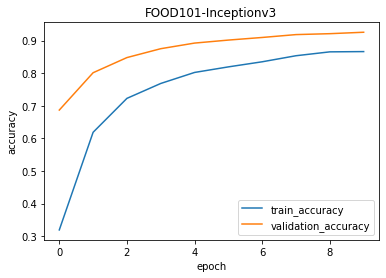

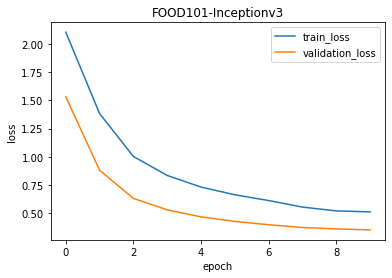

In [ ]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy']) # change acc to accuracy if testing TF 2.0
    plt.plot(history.history['val_accuracy']) # change val_accuracy if testing TF 2.0
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()


def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


plot_accuracy(history,'FOOD101-Inceptionv3')
plot_loss(history,'FOOD101-Inceptionv3')

In [ ]:
def plot_cm(model):
  img_width, img_height = 299, 299
  validation_data_dir = '/content/food-101/test_mini'
  batch_size = 32

  test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

  validation_generator = test_datagen.flow_from_directory(
      validation_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical',
      shuffle = False)
  test_steps_per_epoch = np.math.ceil(validation_generator.samples / validation_generator.batch_size)
  predictions = model.predict_generator(validation_generator, steps=test_steps_per_epoch)

  predicted_classes = np.argmax(predictions, axis=1)
  true_classes = validation_generator.classes
  class_labels = list(validation_generator.class_indices.keys())
  report = metrics.classification_report(true_classes, predicted_classes)#, target_names=class_labels)
  print(report)
  '''
  import seaborn as sns
  conf_mat = confusion_matrix(true_classes, predicted_classes)
  #conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
  x_axis_labels = class_labels # labels for x-axis
  y_axis_labels = class_labels # labels for y-axis
  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(conf_mat,annot=True,ax = ax,xticklabels=x_axis_labels, yticklabels=y_axis_labels)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  '''
  from sklearn.metrics import roc_curve
  from sklearn.metrics import auc
  from sklearn.preprocessing import LabelBinarizer
  from sklearn.metrics import precision_recall_curve
  precision = dict()
  recall = dict()
  for i in range(10):
    precision[i], recall[i], _ = precision_recall_curve(true_classes[:, i],
                                                        predictions[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    
  plt.xlabel("recall")
  plt.ylabel("precision") 
  plt.legend(loc="best")
  plt.title("precision vs. recall curve")
  plt.show()

  return true_classes, predicted_classes

In [ ]:
model_best = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/bestmodel_10class.hdf5',compile = False)
plot_cm(model_best)

Found 2500 images belonging to 10 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


              precision    recall  f1-score   support

           0       0.94      0.95      0.94       250
           1       0.90      0.94      0.92       250
           2       0.95      0.93      0.94       250
           3       0.88      0.92      0.90       250
           4       0.94      0.96      0.95       250
           5       0.94      0.93      0.94       250
           6       0.95      0.93      0.94       250
           7       0.90      0.87      0.89       250
           8       0.93      0.90      0.91       250
           9       0.93      0.92      0.92       250

    accuracy                           0.93      2500
   macro avg       0.93      0.93      0.93      2500
weighted avg       0.93      0.93      0.93      2500



IndexError: ignored

In [ ]:

K.clear_session()
model_best = load_model('/content/bestmodel_10class.hdf5',compile = False)
#model_best.save('/content/drive/MyDrive/Colab Notebooks/bestmodel_10class.hdf5')

##Predict Multiple Images

In [ ]:
def predict_class(model, images, show = True):
  predicted_classes = list()
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img = preprocess_input(img)                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]
    predicted_classes.append(pred_value)
    #print(pred)
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()
  return predicted_classes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


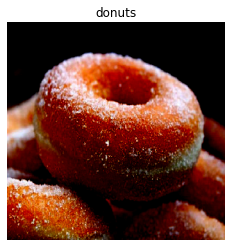

In [ ]:
# Make a list of images and test the trained model
images = []
imagepath = '/content/'
images.append(imagepath+'donut.jpg')
#images.append(imagepath+'chocolate_cake.jpg')
#images.append(imagepath+'red_velvet_cake.jpg')
predicted_classes = predict_class(model_best, images, True)

In [ ]:
#images =['/content/hawaii_pizza.jpg']
#predicted_classes=['pizza']

In [ ]:
def extract_feature(images):
  img = images[0]
  img = image.load_img(img, target_size=(299, 299))
  img = image.img_to_array(img)                    
  img = np.expand_dims(img, axis=0)         
  img = preprocess_input(img)     

  inception = InceptionV3(weights='imagenet', include_top=False)
  #incept_res = applications.InceptionResNetV2(weights='imagenet', include_top=False)
  x = inception.output
  features = GlobalAveragePooling2D()(x)
  

  model = Model(inputs=inception.input, outputs=features)
  feature = model.predict(img)
                      
  
  return feature

In [ ]:
%%time
input_feature = extract_feature(images)

CPU times: user 3.01 s, sys: 77 ms, total: 3.08 s
Wall time: 3.07 s


In [ ]:
input_feature_key = []
for i in range(len(predicted_classes)):
  for food, id in food_key.items():  
    if food == predicted_classes[i]:
      id = int(id)
      input_feature_key.append(id)

##KNN Algorithm (Find First Image)

In [ ]:
def euclidean_distance(row1, row2):
	distance = 0.0
	for i in range(len(row1)-1):
		distance += (row1[i] - row2[i])**2
	return sqrt(distance)

In [ ]:
def nearest_neighbors(neighbor_num,input_feature,features):
  key = input_feature_key[0]
  distances = list()
  for i in range(food_cumulative[key],food_cumulative[key+1]):
    dist = euclidean_distance(input_feature[0],features[i])
    distances.append((i, dist))
  distances.sort(key=lambda tup: tup[1])
  neighbors = list()
  for i in range(neighbor_num):
	  neighbors.append(distances[i][0])
  return neighbors

In [ ]:
neighbor_num = 3
neighbors = nearest_neighbors(neighbor_num,input_feature,features)
nearest_id = []
for i in range(neighbor_num):
  item_id = neighbors[i]-food_cumulative[input_feature_key[0]]+ 1
  nearest_id.append(item_id)

In [ ]:
predict_class_path = '/content/drive/MyDrive/Colab Notebooks/Final Project/Recipes5k/images/'+predicted_classes[0]
#predict_class_path = '/content/drive/MyDrive/2020/ML//Recipes5k/images/'+predicted_classes[0]
image_list = []
images = os.listdir(predict_class_path)
for i in range(neighbor_num):
  image_list.append(images[nearest_id[i]])
  

In [ ]:
image_list

['20_birthday_cake_donuts_hostedLargeUrl.jpg',
 '5_homemade_glazed_doughnuts_hostedLargeUrl.jpg',
 '2_baked_pumpkin_donut_holes_hostedLargeUrl.jpg']

## Fetch Ingredients

In [ ]:
food_name_list = []
for item in image_list:
  name = item.split("_")
  name.remove(name[-1])
  name.remove(name[0])
  for i in range(len(name)):
    name[i] = name[i].capitalize()
  newname = ' '.join(name)
  food_name_list.append(newname)

In [ ]:
food_name_list 

['Birthday Cake Donuts',
 'Homemade Glazed Doughnuts',
 'Baked Pumpkin Donut Holes']

In [ ]:
#food_name_list = ['Vegetarian Cauliflower Crust Pizza', 'Hawaiian Pizza', 'Cowboy Pizza']

In [ ]:
ingredient_set = []
for i in range(len(food_name_list)):
  file1 = open('/content/drive/MyDrive/Colab Notebooks/Final Project/Recipes5k/annotations/classes_Recipes5k.txt', 'r')
  file2 = open('/content/drive/MyDrive/Colab Notebooks/Final Project/Recipes5k/annotations/ingredients_Recipes5k.txt', 'r')
  #file1 = open('/content/drive/MyDrive/2020/ML/Recipes5k/annotations/classes_Recipes5k.txt', 'r')
  #file2 = open('/content/drive/MyDrive/2020/ML/Recipes5k/annotations/ingredients_Recipes5k.txt', 'r')
  count = 0
  
  while True: 
    count += 1
    line = file1.readline() 
    line2 = file2.readline()
    if line.strip() == food_name_list[i]:
      print(food_name_list[i])
      print('Ingredients: \n')
      print(line2.strip())
      print('\n')
    if not line: 
        break
    #print("Line{}: {}".format(count, line.strip())) 
  
  file1.close()
  file2.close() 

Birthday Cake Donuts
Ingredients: 

cake donuts,all-purpose flour,baking powder,baking soda,ground nutmeg,granulated sugar,milk,sour cream,large eggs,butter,vanilla extract,rainbow sprinkles,glaze,powdered sugar,vanilla,sprinkles


Homemade Glazed Doughnuts
Ingredients: 

whole milk,sugar,active dry yeast,large eggs,unsalted butter,all-purpose flour,salt,shortening,powdered sugar,vanilla,cold water


Baked Pumpkin Donut Holes
Ingredients: 

doughnut holes,all-purpose flour,baking powder,pumpkin pie spice,ground nutmeg,salt,pumpkin pur\u00e9e,light brown sugar,large eggs,milk,unsalted butter,vanilla,cinnamon sugar,granulated sugar,ground cinnamon




##UI Create


In [1]:
!pip install -U ipykernel

Requirement already up-to-date: ipykernel in /usr/local/lib/python3.6/dist-packages (5.4.3)


In [2]:
!pip install -q streamlit

     |████████████████████████████████| 7.5MB 6.3MB/s 
     |████████████████████████████████| 112kB 47.3MB/s 
     |████████████████████████████████| 163kB 47.9MB/s 
     |████████████████████████████████| 81kB 6.6MB/s 
     |████████████████████████████████| 4.5MB 46.4MB/s 
     |████████████████████████████████| 71kB 5.6MB/s 


In [3]:
!pip install streamlit==0.69

     |████████████████████████████████| 7.4MB 5.1MB/s 
     |████████████████████████████████| 133kB 45.8MB/s 
     |████████████████████████████████| 7.2MB 23.5MB/s 
     |████████████████████████████████| 71kB 6.5MB/s 
ERROR: botocore 1.19.58 has requirement urllib3<1.27,>=1.25.4; python_version != "3.4", but you'll have urllib3 1.24.3 which is incompatible.
  Found existing installation: streamlit 0.75.0
    Uninstalling streamlit-0.75.0:
      Successfully uninstalled streamlit-0.75.0


In [4]:
!pip install pyngrok

  Created wheel for pyngrok: filename=pyngrok-5.0.1-cp36-none-any.whl size=18822 sha256=d12b08cb8c14fbd8204437a78127f14c21a40985ac386c77f5a57a3b33ee6c8d
  Stored in directory: /root/.cache/pip/wheels/94/01/05/d39efb8f6b40a411354b4168ca9dda99e6f8d586e458e97551
Successfully built pyngrok


In [5]:
!ngrok authtoken 1nBoaAhl519hGAdeffuZNdrN9ak_69zQxEjkAgwABaPJsJdCA

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [6]:
%%writefile score.py
from tempfile import NamedTemporaryFile
import streamlit as st
from PIL import Image
import requests
from io import BytesIO
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image 
import urllib
import os
from tensorflow.keras.models import Model
from math import sqrt
import pandas as pd
st.set_option('deprecation.showfileUploaderEncoding',False)
st.title("Food Image to Recipe Generator")
st.text("Provide URL of Food Image For Classification")

#@st.cache(allow_output_mutation=True)
def predict_class(model, images):
  predicted_classes = list()
    #img = tf.image.decode_jpeg(images, channels=3)
  img = image.load_img(images, target_size=(299, 299))
  img = image.img_to_array(img)                    
  img = np.expand_dims(img, axis=0)         
  img = preprocess_input(img)                                      

  pred = model.predict(img)
  index = np.argmax(pred)
  food_list.sort()
  pred_value = food_list[index]
  predicted_classes.append(pred_value)
  return predicted_classes

def extract_feature(images):
  #img = images[0]
  
  img = image.load_img(images, target_size=(299, 299))
  #img = image.load_img(images, target_size=(299, 299))
  img = image.img_to_array(img)                    
  img = np.expand_dims(img, axis=0)         
  img = preprocess_input(img)     

  inception = InceptionV3(weights='imagenet', include_top=False)
  x = inception.output
  features = GlobalAveragePooling2D()(x)
  

  model = Model(inputs=inception.input, outputs=features)
  feature = model.predict(img)
                      
  return feature
def euclidean_distance(row1, row2):
	distance = 0.0
	for i in range(len(row1)-1):
		distance += (row1[i] - row2[i])**2
	return sqrt(distance)
def nearest_neighbors(neighbor_num,input_feature,features):
  key = input_feature_key[0]
  distances = list()
  for i in range(food_cumulative[key],food_cumulative[key+1]):
    dist = euclidean_distance(input_feature[0],features[i])
    distances.append((i, dist))
  distances.sort(key=lambda tup: tup[1])
  neighbors = list()
  for i in range(neighbor_num):
	  neighbors.append(distances[i][0])
  return neighbors

def output(images):
  model_best = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/bestmodel_10class.hdf5',compile = False)
  #model_best = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Final Project/Inception101.hdf5',compile = False)
  input_feature = extract_feature(images)
  feature_path = '/content/drive/MyDrive/Colab Notebooks/Final Project/data_feature.npy'
  features = np.load(feature_path)
  predicted_classes = predict_class(model_best, images)
  test_list = os.listdir('/content/drive/MyDrive/Colab Notebooks/Final Project/Recipes5k/images/')
  test_list = sorted(test_list)
  food_key= {} 
  food_value = np.linspace(0, len(test_list)-1, num = len(test_list)).tolist()
  for key in test_list: 
    for value in food_value: 
      food_key[key] = value 
      food_value.remove(value) 
      break    
  global input_feature_key 
  input_feature_key = []
  for i in range(len(predicted_classes)):
    for food, id in food_key.items():  
      if food == predicted_classes[i]:
        id = int(id)
        input_feature_key.append(id)
  food_num = []
  for item in test_list:
    path = '/content/drive/MyDrive/Colab Notebooks/Final Project/Recipes5k/images/'+item
    num = len(os.listdir(path))
    food_num.append(num)
  global food_cumulative
  food_cumulative = []
  for i in range(len(food_num)):
    if i==0:
      food_cumulative.append(food_num[0])
    else :
      num = food_cumulative[i-1]+food_num[i]
      food_cumulative.append(num)
  food_cumulative.insert(0,0)  
  neighbor_num = 3
  neighbors = nearest_neighbors(neighbor_num,input_feature,features)
  nearest_id = []
  for i in range(neighbor_num):
    item_id = neighbors[i]-food_cumulative[input_feature_key[0]]+ 1
    nearest_id.append(item_id)

  predict_class_path = '/content/drive/MyDrive/Colab Notebooks/Final Project/Recipes5k/images/'+predicted_classes[0]
  image_list = []
  images = os.listdir(predict_class_path)
  for i in range(neighbor_num):
    image_list.append(images[nearest_id[i]])
  global food_name_list
  food_name_list = []
  for item in image_list:
    name = item.split("_")
    name.remove(name[-1])
    name.remove(name[0])
    for i in range(len(name)):
      name[i] = name[i].capitalize()
    newname = ' '.join(name)
    food_name_list.append(newname)
  global ingredient_set
  ingredient_set = []
  for i in range(len(food_name_list)):
    file1 = open('/content/drive/MyDrive/Colab Notebooks/Final Project/Recipes5k/annotations/classes_Recipes5k.txt', 'r')
    file2 = open('/content/drive/MyDrive/Colab Notebooks/Final Project/Recipes5k/annotations/ingredients_Recipes5k.txt', 'r')
    count = 0
  
    while True: 
      count += 1
      line = file1.readline() 
      line2 = file2.readline()
      if line.strip() == food_name_list[i]:
        #print(food_name_list[i])
        #print('Ingredients: \n')
        #print(line2.strip())
        ingredient_set.append(line2.strip())

      if not line: 
        break
    #print("Line{}: {}".format(count, line.strip())) 
  
    file1.close()
    file2.close() 
  return food_name_list, ingredient_set

food_list = ['baklava','beef_carpaccio','caesar_salad','chocolate_cake','donuts','filet_mignon','garlic_bread','huevos_rancheros','lasagna','red_velvet_cake']
#food_list = os.listdir('/content/drive/MyDrive/Colab Notebooks/Final Project/Recipes5k/images')
path = st.text_input('Enter Image URL to Classify.. ','https://www.livewellbakeoften.com/wp-content/uploads/2019/01/Red-Velvet-Cake-8.jpg')
if path is not None:
  content = requests.get(path).content
  
  st.write("Predicted Recipe Ingredients :")
  with st.spinner('Generating....'):
    with open('output.jpg', 'wb') as handler:
      handler.write(content)
    images = 'output.jpg'
    output(images)
    st.write("Recipe1: ")
    st.write(food_name_list[0])
    st.write("")
    st.write(ingredient_set[0])
    st.write("Recipe2: ")
    st.write(food_name_list[1])
    st.write("")
    st.write(ingredient_set[1])
  st.write("")
  image = Image.open(BytesIO(content))
  st.image(image,caption= 'Input Food Image', use_column_width = True)
  data = pd.DataFrame({
    'lat' : [25.0264929,25.0571641,25.0318366,25.0386702],
    'lon' : [121.5340294,121.5381541,121.5368056,121.5243915]#,121.5360725]
  })
  st.map(data)
  #25.0361156],

Writing score.py


In [7]:
!nohup streamlit run score.py &

nohup: appending output to 'nohup.out'


In [ ]:
!streamlit run --server.port 80 score.py >/dev/null

2021-01-22 02:58:45.997676: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-01-22 02:58:49.587345: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-01-22 02:58:49.629467: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-01-22 02:58:49.707667: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-01-22 02:58:49.707732: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (b91ceb0fb37f): /proc/driver/nvidia/version does not exist
2021-01-22 02:58:49.708385: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-01-22 02:58:55.487241: I tensorflow/compiler/mlir/mlir_graph_optimizati

In [7]:
from pyngrok import ngrok

public_url = ngrok.connect(port='5081')
public_url

<NgrokTunnel: "http://0ce73ebe67a3.ngrok.io" -> "http://localhost:80">

In [16]:
ngrok.kill()

In [ ]:

!cat nohup.out


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://35.227.173.129:8501


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8502
  External URL: http://35.227.173.129:8502

